# Rossmann Store Sales - Final Project @ Statistical Monitoring and Anomaly Detection
## Group 7
Almog Asraf - 313200511 | Daniel Pidtylok - 322558867 | Nir Levanon - 313160715

For our project, we've decided to answer the following demand:
### *Which stores are underperforming, when compared to their relevant counterparts?*

#### Methods of Analysis:
In order to answer the assignment's requirements, we've decided to use the following techniques:
1. Using SPC, create an X_bar diagram, and check which stores have results which are 2 sigmas below the CL. Return all problematic stores as a list of IDs. This method will help us find which stores have a large amount of days with low revenue. (Further explanation can be seen at the relevant area in the notebook)
2. Using a serial sampling process, find out which stores have a "malfunctioning" process, by defining a "malfunction" as a date for a store, where the revenue is 2 sigmas below the CL, as calculated in the former method. Return all problematic stores as a list of IDs. This method will help us find which stores have a recent "bad streak". (Further explanation can be seen at the relevant area in the notebook)
3. Finally, create a set from both lists, in order to locate the most problematic stores which management should focus on first.

#### Notes:
1. We've decied to define *"relevant counterparts"*, as other stores, which were open at the same time periods, who are of the same `StoreType` and `Assortment`.
2. In order to further narrow down the scope of the demand, we'll also only look into stores which don't have `Promo` or `Promo2` active at the same time period. Also, we'll only look at data where `SchoolHoliday` is `False` and `StateHoliday` is `0`, in order to reduce varaiables.
3. Because of the extensive amount of data available, we've decided to focus our demand only for stores of `StoreType == a` and `Assortment == a`.
4. We define *"underpeforming"* as stores which are haves their `Sales` parameter below the LCL, which will be 2 sigmas below the CL. We've decided to drop `Customers` and use `Sales` only, after seeing they have a relatively high correlation of ~0.94.
5. This method can be used for all combinations of `StoreType` and `Assortment`, for this project we've decided to focus on one combination, in order to prove the usefullness of the method.
6. For the scope of this task, we'll only focus on locating problematic stores, and won't attempt to explain what causes the problem. If requested, we could take the problematic stores and check for correlating features.
7. Before performing the statistical analysis, we first started by exploring the data and cleaning it up, preparing it for analysis.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from sklearn.cluster import KMeans
import statistics
from fitter import Fitter, get_common_distributions, get_distributions
import hvplot
import hvplot.pandas
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Loading files into pandas dataframes:
path = "./rossmann-store-sales/"
store = pd.read_csv(f"{path}store.csv", encoding="utf8")
train = pd.read_csv(f"{path}train.csv", encoding="utf8")

C:\Users\levan\AppData\Local\Temp\ipykernel_21168\2917182680.py:18: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f"{path}train.csv", encoding="utf8")


#### First Exploration:

In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


### Dataset Description
We are provided with historical sales data for 1,115 Rossmann stores. Note that some stores in the dataset were temporarily closed for refurbishment.

#### Files
* train.csv - historical data including Sales
* sample_submission.csv - a sample submission file in the correct format
* store.csv - supplemental information about the stores
#### Data Fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Dataset Exploration💡
#### Summary Statictics and info of each DF:

In [9]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


#### Data Cleanup

We'll start by converting values of columns into usable types:

In [45]:
train['Date'] = pd.to_datetime(train['Date'])                   # Was a string before.
train['Open'] = train['Open'].astype(bool)                      # Was numbers before.
train['Promo'] = train['Promo'].astype(bool)                    # Was numbers before.
train['SchoolHoliday'] = train['SchoolHoliday'].astype(bool)    # Was numbers before.
train['StateHoliday'] = train['StateHoliday'].replace({0:'0'})  # We got 5 values, when we should have 4. So, we are merging 0 with '0'.
store['Promo2'] = store['Promo2'].astype(bool)                  # Was numbers before.

We'll merge both tables, in order to filter out the irrlevant stores:

In [46]:
united_df = pd.merge(train, store, on='Store')
united_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,True,True,0,True,c,a,1270.0,9.0,2008.0,False,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,True,True,0,True,c,a,1270.0,9.0,2008.0,False,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,True,True,0,True,c,a,1270.0,9.0,2008.0,False,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,True,True,0,True,c,a,1270.0,9.0,2008.0,False,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,True,True,0,True,c,a,1270.0,9.0,2008.0,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,True,False,0,True,d,c,5350.0,NaN,NaN,True,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,True,False,0,True,d,c,5350.0,NaN,NaN,True,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,True,False,0,True,d,c,5350.0,NaN,NaN,True,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,True,False,0,True,d,c,5350.0,NaN,NaN,True,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [52]:
relevant_df = united_df.loc[
  (united_df['Open']) &
  (united_df['Promo'] == False) &
  (united_df['Promo2'] == False) &
  (united_df['SchoolHoliday'] == False) &
  (united_df['StateHoliday'] == '0') & 
  (united_df['StoreType'] == 'a') &
  (united_df['Assortment'] == 'a')
]
relevant_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
3774,5,6,2015-07-25,2030,228,True,False,0,False,a,a,29910.0,4.0,2015.0,False,NaN,NaN,NaN
3781,5,6,2015-07-18,2108,241,True,False,0,False,a,a,29910.0,4.0,2015.0,False,NaN,NaN,NaN
3788,5,6,2015-07-11,2023,228,True,False,0,False,a,a,29910.0,4.0,2015.0,False,NaN,NaN,NaN
3789,5,5,2015-07-10,4252,530,True,False,0,False,a,a,29910.0,4.0,2015.0,False,NaN,NaN,NaN
3790,5,4,2015-07-09,4601,540,True,False,0,False,a,a,29910.0,4.0,2015.0,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010785,1108,1,2013-01-14,5126,620,True,False,0,False,a,a,540.0,4.0,2004.0,False,NaN,NaN,NaN
1010787,1108,6,2013-01-12,1859,204,True,False,0,False,a,a,540.0,4.0,2004.0,False,NaN,NaN,NaN
1010794,1108,6,2013-01-05,2113,195,True,False,0,False,a,a,540.0,4.0,2004.0,False,NaN,NaN,NaN
1010795,1108,5,2013-01-04,5491,640,True,False,0,False,a,a,540.0,4.0,2004.0,False,NaN,NaN,NaN


As we can see, we have an abundance of data that can be used after applying our planned fitlers.

Let's remove the redundant columns and check correlations:

C:\Users\levan\AppData\Local\Temp\ipykernel_21168\1324861441.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient(cmap="GnBu")


,Store,DayOfWeek,Sales,Customers
Store,1.000000,0.001363,0.072638,0.077416
DayOfWeek,0.001363,1.000000,-0.121599,-0.165115
Sales,0.072638,-0.121599,1.000000,0.940483
Customers,0.077416,-0.165115,0.940483,1.000000


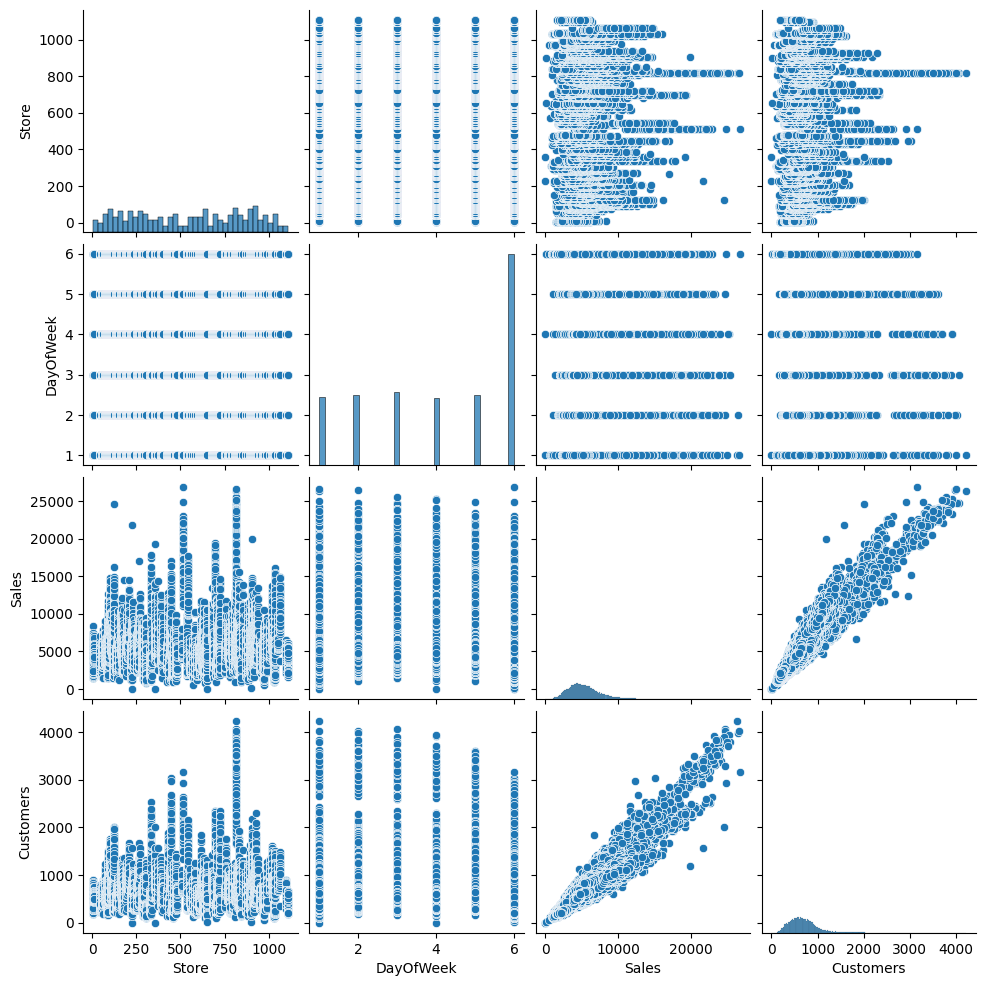

In [53]:
df = relevant_df.filter(items=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers'])
sns.pairplot(df)
df.corr().style.background_gradient(cmap="GnBu")

#### Conclusions:
1. As we can see from the results, we have a high correlation between `Sales` and `Customers`. As such, we'll drop `Customers` in order to remove a dimension, and reduce the complexity of the issues.
2. We see there is no meaningful correlation between `Sales` and `DayOfWeek`, thus we'll decide to drop `DayOfWeek`.

In [55]:
df.drop(columns=['DayOfWeek', 'Customers'], inplace=True)
df

,Store,Date,Sales
3774,5,2015-07-25,2030
3781,5,2015-07-18,2108
3788,5,2015-07-11,2023
3789,5,2015-07-10,4252
3790,5,2015-07-09,4601
...,...,...,...
1010785,1108,2013-01-14,5126
1010787,1108,2013-01-12,1859
1010794,1108,2013-01-05,2113
1010795,1108,2013-01-04,5491


#### Visualization
In order to understand whether we're looking at a normal distribution, we'll visualise the distribution of `Sales`:

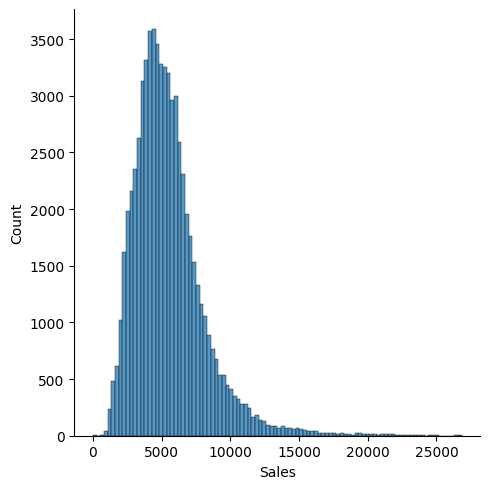

In [78]:
sns.displot(df['Sales'],bins=100)

Fitting 4 distributions: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,5.307365e-09,2792.373532,-2.031280e+06,inf,0.035678,6.751896e-75
norm,4.021555e-08,3514.884352,-1.894956e+06,inf,0.088443,0.000000e+00
lognorm,3.971306e-07,2400.128412,-1.740768e+06,inf,0.734547,0.000000e+00
gamma,4.968021e-07,inf,-1.725692e+06,5.666263,0.999605,0.000000e+00


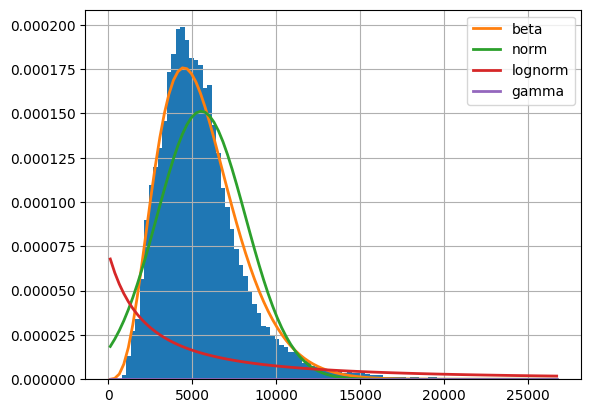

In [79]:
sales = df['Sales'].values
f = Fitter(sales,
           distributions=['gamma',
                          "beta",
                          "lognorm",
                          "norm"])
f.fit()
f.summary()

##### Conclusions:
1. As can be seen above, it seems we have a slightly skewed normal distribution with a long right tail. This perhaps can be attributed to the fact that we've yet to seperate the data of each store, and are currently comparing between individual stores and their performance.
2. This distribution is good enough for us to move forward and start using statistical analysis methods in order to create a CL, UCL, and LCL.

#### Dates Available in the dataframe
In order to perform the calculations, we'll need to divide the dataframe's data by different ranges of dates, so we won't use the same data for each step, and thus ruin our test results.

We'll need three different ranges of dates, for the following uses:
1. The first range will be used for creating the estimators which to be used in the X_bar Diagram for creating the CL, LCL, and UCL.
2. The second range will be used for analysing whether stores are underpeforming with the X_bar Diagram.
3. The third range will be used for analysing whether stores are underpeforming with the serial sampling process.
We'll explore the available dates and their amounts:

In [65]:
dates = df[['Date']].value_counts(sort=False, ascending=True)
dates

Date      
2013-01-03     19
2013-01-04     19
2013-01-05    182
2013-01-12    194
2013-01-14    194
             ... 
2015-07-21     36
2015-07-22     36
2015-07-23     25
2015-07-24     25
2015-07-25    182
Length: 411, dtype: int64

Dates as individuals are a bit hard to use in order to define three distinct ranges.

Let's try the distribution by years instead:

In [66]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
dates_by_year = df['Year'].value_counts(sort=False, ascending=True)
dates_by_year

2015    15456
2014    25524
2013    26346
Name: Year, dtype: int64

We can now see that we have a relatively similar number of days both in 2013 & 2014, and a smaller number in 2015.

Thus, we'll use the the ranges in the following manner:
1. 2013 - 1st range for estimators & CL, LCL, and UCL.
2. 2014 - 2nd range for analysing performance with X_bar diagram.
3. 2015 - 3rd range for analysing performance with a serial sampling process.

At this time, let's also check how many dates we have for each store:

5       338
6       338
8       358
10      327
44      355
       ... 
1035    338
1053    327
1066    346
1098    338
1108    338
Name: Store, Length: 194, dtype: int64

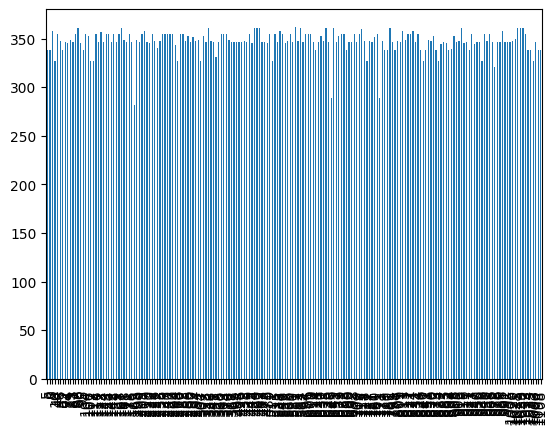

In [69]:
dates_for_store = df['Store'].value_counts(sort=False, ascending=True)
dates_for_store.plot.bar()
dates_for_store

According to the results we've got, we can say that generally speaking, we have quite the similiar amount of sample per store, and all stores have a sufficent number of samples.

# Statistical Analysis 📊
### SPC - X_bar Diagram
#### Intended Process
Because we're in a situation where the mean value and the standard deviation are unknown,  we'll start by calculating the estimators X_bar and s, using the following method:
##### For each sampling, we'll calculate the sampling's average, X_bar and the standard deviation, s:
$$
σ_j=s_j=\sqrt{\frac{(\sum_{i=1}^{n} (x_{ij}-\bar{x}_j)^2)}{n-1}}=\sqrt{\frac{\sum_{i=1}^{n} x_{ij}^2-n\bar{x}_j^2}{n-1}}
$$
$$
\bar{\bar{x}}=\frac{\sum{\bar{x}_j}}{k}
$$
$$
\bar{s}=\frac{\sum{s_{j}}}{k}
$$

We'll use 10 sampling groups with 100 samples in each:
\begin{gather*}
k=10\\
n=100
\end{gather*}

In [103]:
import math
k = 10
n = 100

df_2013 = df[df['Year'] == 2013][['Sales', 'Date']]
date_samples = df_2013['Date'].sample(n=k, random_state=42) # First, we want to sample the dates we want to sample from. The n here needs to be equal to the n in for loop.
# samples = pd.DataFrame(columns=['x_sum', 'x_bar','s_j']) # Setting an empty df for samples
samples = []
date_samples = date_samples.to_frame()
i = 1
for id, value in date_samples.iterrows():
    # Sample data for store sales
    value = date_samples.loc[id]['Date']
    sales_samples = df_2013[df_2013['Date']==value]['Sales'].sample(n=n, replace=True, random_state=42)
    # Calculate the mean and standard deviation of the sampled data
    x_sum = sum(sales_samples**2)
    x_bar = sales_samples.mean()
    s_j = math.sqrt( (x_sum - (n * (x_bar**2))) / (n - 1) )
    samples.append({'x_sum': x_sum, 'x_bar': x_bar,'s_j': s_j})
    i += 1
samples = pd.DataFrame(samples)
samples

,x_sum,x_bar,s_j
0,3034143652,5256.44,1654.890227
1,4972403382,6452.46,2858.585115
2,3632353532,5591.46,2260.577916
3,3381760073,5573.85,1666.605122
4,3298685070,5437.62,1858.406898
5,3979773588,5871.74,2318.220593
6,3548751627,5184.11,2949.494012
7,2666039123,4871.07,1721.248163
8,3107392591,5171.77,2090.556201
9,2969544522,5136.38,1829.347103


Now we'll calculate the CL, UCL, and LCL:
$$
CL_{\bar{x}}=\bar{\bar{x}}
$$
$$
UCL_{\bar{x}}=\bar{\bar{x}}+A_3*\bar{s}
$$
$$
LCL_{\bar{x}}=\bar{\bar{x}}-A_3*\bar{s}
$$
When:
$$
A_3=\frac{3}{c_4\sqrt{n}}
$$
$$
c_4=\frac{4(n-1)}{4n-3}
$$

In [113]:
c_4 = (4 * (n-1)) / (4*n - 3)
A_3 = 3 / (c_4 * math.sqrt(n))
CL_x = samples['x_bar'].mean()
s_bar = samples['s_j'].mean()
print('CL_x', CL_x)
print('s_bar', s_bar)
UCL_x = CL_x + A_3 * s_bar
print('UCL_x', UCL_x)
LCL_x = CL_x - A_3 * s_bar
print('LCL_x', LCL_x)

CL_x 5454.6900000000005
s_bar 2120.7931349558066
UCL_x 6092.534601952618
LCL_x 4816.845398047383


Now that we have the CL, UCL, and LCL, we can sample the data using the 2nd range of dates from 2014, in order to find which stores are underperforming.

We'll take the 100 samples from each store, and check which stores have more then 5% of days which are below the LCL.

For these underperforming stores, we'll plot their X_bar diagram.

In [153]:
df_2014 = df[df['Year'] == 2014][['Store', 'Sales', 'Date']]
stores = df_2014['Store'].unique()
sampling_by_stores_df = pd.DataFrame(columns=['Store', 'Sales'])
for store in stores:
  store_samples = df_2014[df_2014['Store'] == store][['Store', 'Sales']].sample(n=n, random_state=42, replace=True)
  # print(store_samples)
  sampling_by_stores_df = pd.concat([sampling_by_stores_df, store_samples])
sampling_by_stores_df['Malfunction'] = sampling_by_stores_df['Sales'] < LCL_x

alerting_amount = 90

underperforming_stores = sampling_by_stores_df[['Store', 'Malfunction']][sampling_by_stores_df['Malfunction']].groupby(['Store']).count()
overperforming_stores = sampling_by_stores_df[['Store', 'Malfunction']][sampling_by_stores_df['Malfunction'] == False].groupby(['Store']).count()
underperforming_stores['Underperforming'] = underperforming_stores['Malfunction'] > alerting_amount
# overperforming_stores
most_underperforming_stores = underperforming_stores[underperforming_stores['Underperforming']]
len(most_underperforming_stores)

49

We've found 49 stores out of 149 who are the most underperforming.

To present 49 diagrams is a bit overwhelming, so instead of presenting all of their diagrams, we'll present 5 of them in random:

In [ ]:
# TODO: Take the 5 stores at random and present their samples in an x_bar diagram

def create_x_diagram(samples=None):
  fig, ax = plt.subplots()
  plt.axhline(y = CL_x, color = 'black', linestyle = '-')
  plt.axhline(y = UCL_x, color = 'black', linestyle = '-')
  plt.axhline(y = LCL_x, color = 'r', linestyle = '-')
  # TODO: Add logic which adds the samples as a scatter plot.
create_x_diagram()